# Test


In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio


In [8]:
# Basic processing: Normalize each band for visualization
def normalize_band(band):
    band_min, band_max = band.min(), band.max()
    return (band - band_min) / (band_max - band_min)

In [ ]:
# Load all AVIRIS hyperspectral images in the sample data folder
import os
import rasterio

aviris_dir = os.path.join('..', 'sample data', 'aviris_hyperspectral_data')
tif_files = [f for f in os.listdir(aviris_dir) if f.endswith('.tif')]
imgs = {}
for tif_file in tif_files:
    tif_path = os.path.join(aviris_dir, tif_file)
    with rasterio.open(tif_path) as src:
        img = src.read()  # Shape: (bands, height, width)
        imgs[tif_file] = img
        print(f"Loaded {tif_file} with shape: {img.shape} and bands: {src.count}")

how to load, visualize, and analyze AVIRIS hyperspectral images, including endmember extraction and spectral library matching.


Image: 19920612_AVIRIS_IndianPine_EW-line_R.tif


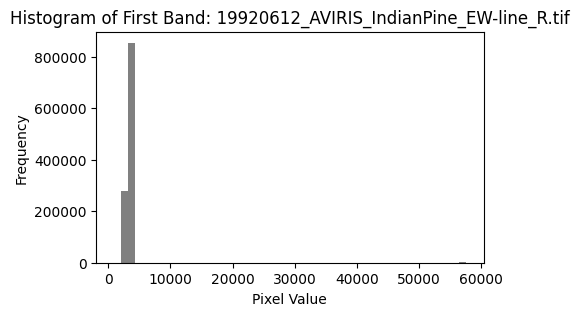

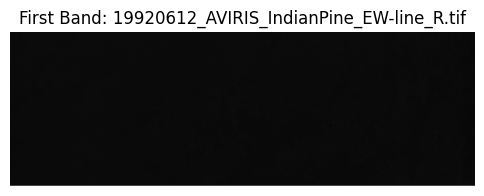

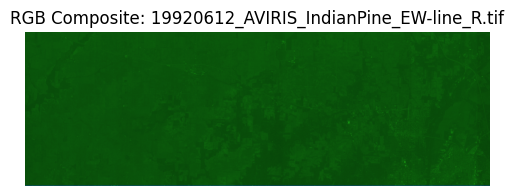


Image: 19920612_AVIRIS_IndianPine_NS-line.tif


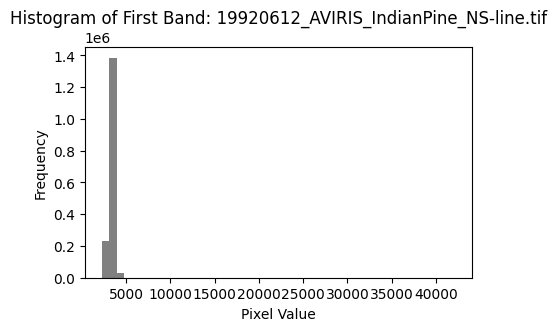

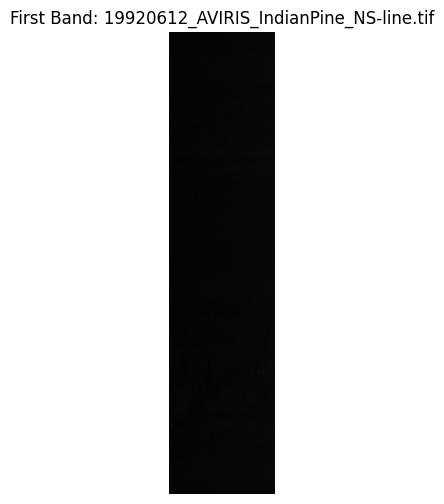

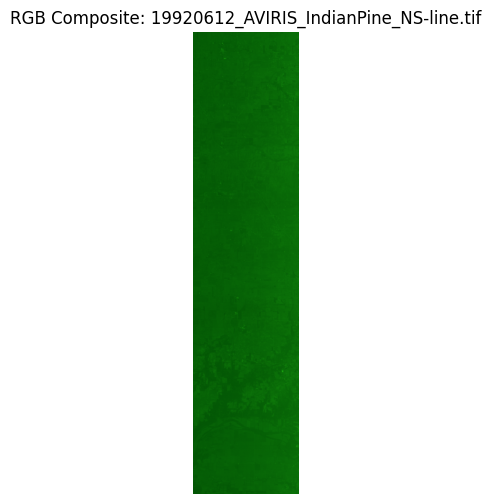


Image: 19920612_AVIRIS_IndianPine_Site3.tif


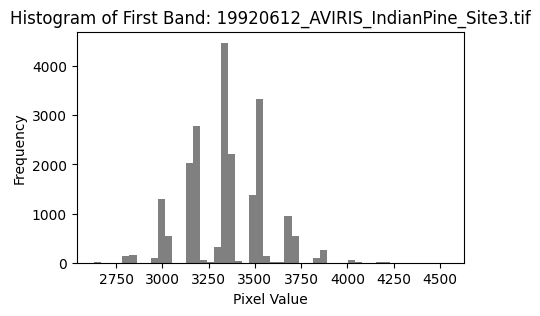

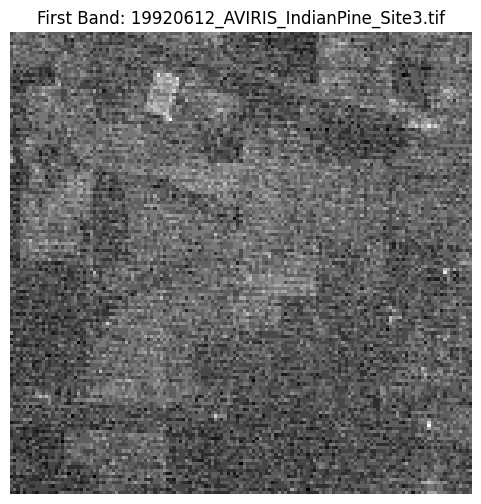

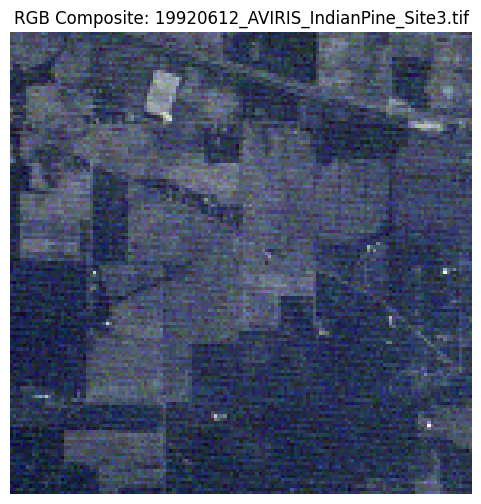

In [40]:
# Plot histograms and visualize bands for all loaded images
for name, img in imgs.items():
    print(f"\nImage: {name}")
    # Plot histogram for the first band
    plt.figure(figsize=(5, 3))
    plt.hist(img[0].ravel(), bins=50, color='gray')
    plt.title(f"Histogram of First Band: {name}")
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()
    # Visualize first band
    plt.figure(figsize=(6, 6))
    plt.title(f"First Band: {name}")
    plt.imshow(normalize_band(img[0]), cmap='gray')
    plt.axis('off')
    plt.show()
    # Visualize RGB composite if possible
    if img.shape[0] >= 3:
        rgb = np.stack([normalize_band(img[2]), normalize_band(img[1]), normalize_band(img[0])], axis=-1)
        plt.figure(figsize=(6, 6))
        plt.title(f"RGB Composite: {name}")
        plt.imshow(rgb)
        plt.axis('off')
        plt.show()

## Endmember Extraction
We will extract endmembers (pure spectral signatures) from each image using the N-FINDR algorithm provided by the spectral library.

## Hyperspectral Image Processing Workflow

1. **Atmospheric Correction:**
   - Raw hyperspectral data is typically in radiance units. The first step is to convert radiance to surface reflectance using atmospheric correction algorithms (e.g., FLAASH, QUAC, or open-source tools like Py6S or PyAtmos).

2. **Dimensionality Reduction:**
   - Hyperspectral data contains hundreds of bands, many of which are highly correlated. Dimensionality reduction (e.g., PCA, MNF) is performed to reduce noise and redundancy, making subsequent analysis more efficient.

3. **Endmember Extraction:**
   - Extract pure spectral signatures (endmembers) from the reflectance data cube using algorithms like N-FINDR, PPI, or K-means clustering.

4. **Spectral Mapping / Classification:**
   - Map the spatial distribution of materials by comparing pixel spectra to endmembers or reference libraries, producing abundance or classification maps.

Assuming data is already in reflectance. If not, apply atmospheric correction here.


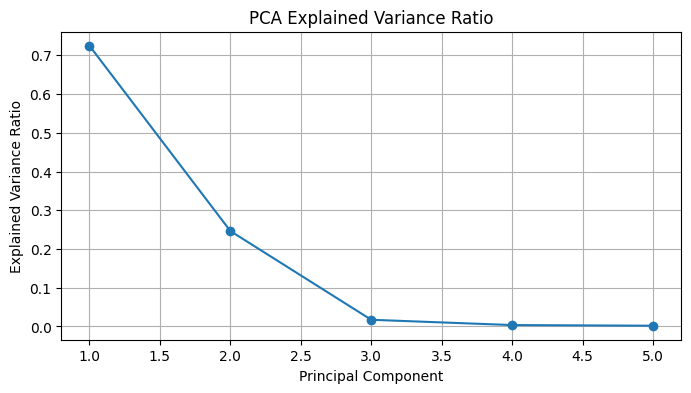

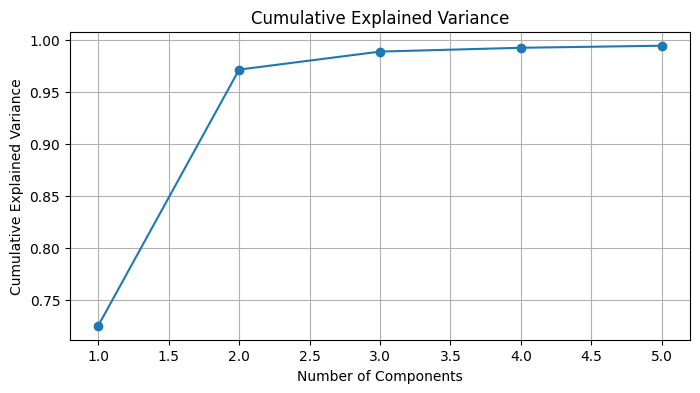

Original bands: 220, PCA components: 5


In [76]:
# 1. Atmospheric Correction (Placeholder)
# In practice, use tools like Py6S, PyAtmos, or external software (ENVI, QGIS) for atmospheric correction.
# Here, we assume the data is already in reflectance. If not, insert your correction code here.
print("Assuming data is already in reflectance. If not, apply atmospheric correction here.")

# 2. Dimensionality Reduction (PCA)
from sklearn.decomposition import PCA

# Use the selected image for demonstration
target_file = '19920612_AVIRIS_IndianPine_Site3.tif'
img = imgs[target_file]

# Reshape to (pixels, bands)
h, w = img.shape[1], img.shape[2]
pixels = img.reshape(img.shape[0], -1).T

# Apply PCA to reduce to 10 components (or as needed)
components = 5  # You can adjust this number
pca = PCA(n_components=components)
pixels_pca = pca.fit_transform(pixels)
# Optionally, reshape back to (components, height, width)
img_pca = pixels_pca.T.reshape(components, h, w)

# Visualize explained variance ratio to decide number of components
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Recommendation:
# Choose the number of components such that the cumulative explained variance reaches ~95% (commonly used threshold).
# Inspect the second plot and select the smallest number of components where the curve flattens or exceeds 0.95.
print(f"Original bands: {img.shape[0]}, PCA components: {pixels_pca.shape[1]}")




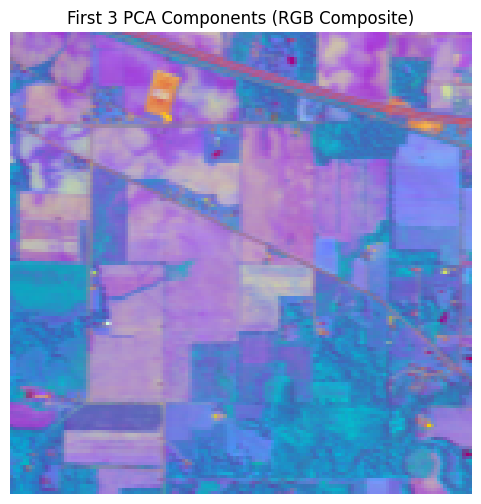

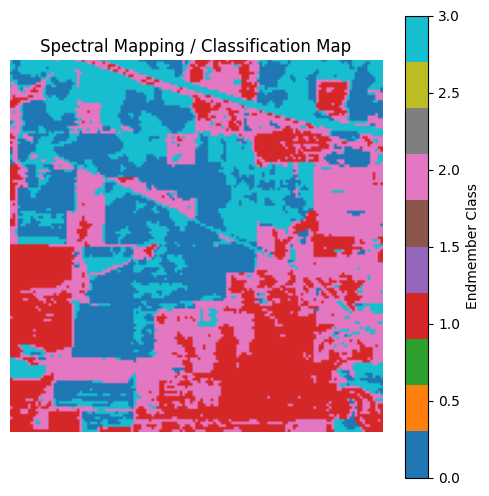

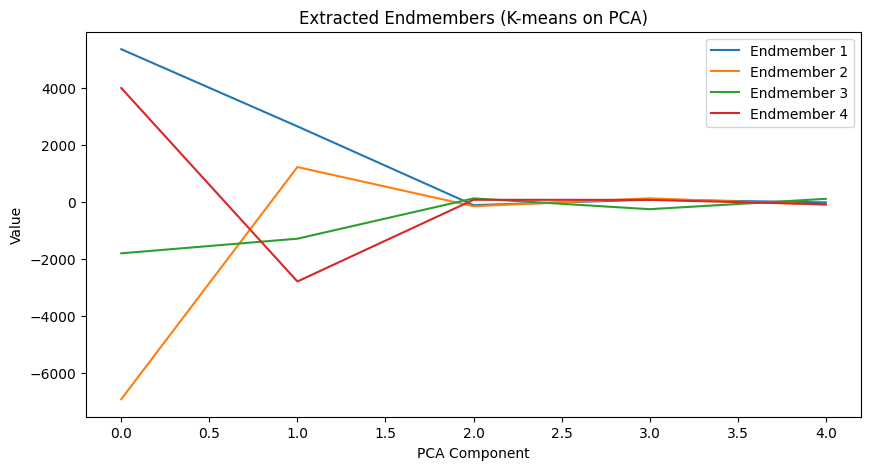

In [63]:
# Visualize the first 3 PCA components as an RGB composite
rgb_pca = np.stack([normalize_band(img_pca[0]), normalize_band(img_pca[1]), normalize_band(img_pca[2])], axis=-1)
plt.figure(figsize=(6, 6))
plt.title("First 3 PCA Components (RGB Composite)")
plt.imshow(rgb_pca)
plt.axis('off')
plt.show()

# 3. Endmember Extraction (K-means on PCA data)
from sklearn.cluster import KMeans
num_endmembers = 4  # You can change this as needed
kmeans = KMeans(n_clusters=num_endmembers, random_state=42)
kmeans.fit(pixels_pca)
endmembers = kmeans.cluster_centers_

# 4. Spectral Mapping / Classification (Assign each pixel to nearest endmember)
labels = kmeans.predict(pixels_pca)
label_map = labels.reshape(h, w)
plt.figure(figsize=(6, 6))
plt.title('Spectral Mapping / Classification Map')
plt.imshow(label_map, cmap='tab10')
plt.axis('off')
plt.colorbar(label='Endmember Class')
plt.show()


plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(endmembers):
    plt.plot(spectrum, label=f'Endmember {i+1}')
plt.title('Extracted Endmembers (K-means on PCA)')
plt.xlabel('PCA Component')
plt.ylabel('Value')
plt.legend()
plt.show()



Extracting endmembers for 19920612_AVIRIS_IndianPine_Site3.tif using K-means


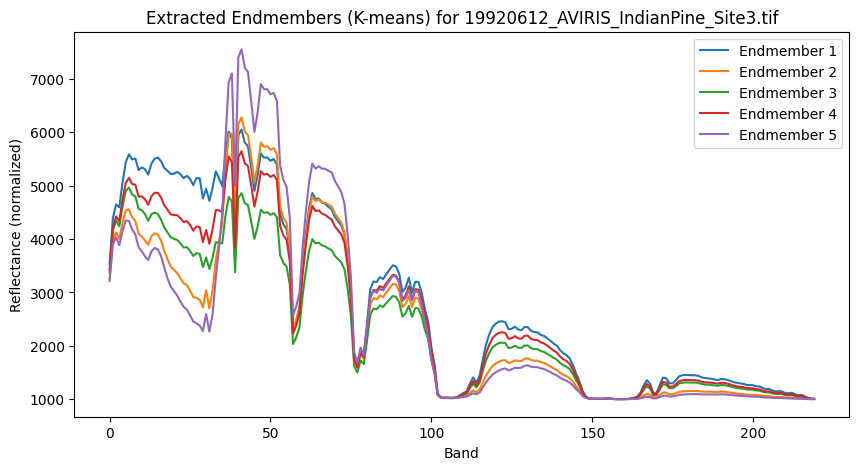

In [67]:
# Extract and plot endmembers using K-means clustering (no spectral library)
from sklearn.cluster import KMeans

# Only process the specified image
target_file = '19920612_AVIRIS_IndianPine_Site3.tif'
imgs = {target_file: imgs[target_file]}

num_endmembers = 5  # You can change this as needed
for name, img in imgs.items():
    print(f"\nExtracting endmembers for {name} using K-means")
    # Reshape image to (pixels, bands)
    h, w = img.shape[1], img.shape[2]
    reshaped = img.reshape(img.shape[0], -1).T  # (pixels, bands)
    # Run K-means
    kmeans = KMeans(n_clusters=num_endmembers, random_state=42)
    kmeans.fit(reshaped)
    endmembers = kmeans.cluster_centers_
    # Plot endmember spectra
    plt.figure(figsize=(10, 5))
    for i, spectrum in enumerate(endmembers):
        plt.plot(spectrum, label=f'Endmember {i+1}')
    plt.title(f'Extracted Endmembers (K-means) for {name}')
    plt.xlabel('Band')
    plt.ylabel('Reflectance (normalized)')
    plt.legend()
    plt.show()

In [ ]:
pip install Py6S

In [70]:
from Py6S import *
import numpy as np

# Example: Simulate surface reflectance for a given wavelength
s = SixS()
s.geometry.solar_z = 30
s.geometry.view_z = 0
s.geometry.month = 7
s.geometry.day = 2
s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.MidlatitudeSummer)
s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)
s.ground_reflectance = GroundReflectance.HomogeneousLambertian(0.2)
s.wavelength = Wavelength(0.55)  # 550 nm

s.run()
print('Simulated surface reflectance:', s.outputs.apparent_reflectance)

ExecutionError: 6S executable not found.

## Spectral Library Matching
We will match the extracted endmembers to reference spectra from the ASTER and USGS spectral libraries to identify possible materials.

In [68]:
# Plot reflectance vs wavelength for each classified endmember using ASTER wavelengths if available
# Get ASTER wavelengths (in micrometers) if present in the database
aster_wavelengths = None
for rec in db.records:
    if hasattr(rec, 'wavelength') and rec.wavelength is not None:
        aster_wavelengths = np.array(rec.wavelength)
        break

for i, spectrum in enumerate(endmembers):
    min_len = min(aster_spectra.shape[1], spectrum.shape[0])
    if aster_wavelengths is not None and len(aster_wavelengths) >= min_len:
        x_axis = aster_wavelengths[:min_len]
        x_label = 'Wavelength (micrometers)'
    else:
        x_axis = np.arange(min_len)
        x_label = 'Band Index'
    plt.figure(figsize=(10, 4))
    plt.plot(x_axis, spectrum[:min_len], label=f'Endmember {i+1} (Reflectance)', linewidth=2)
    plt.title(f'Reflectance vs Wavelength for Endmember {i+1}')
    plt.xlabel(x_label)
    plt.ylabel('Reflectance')
    plt.legend()
    plt.show()

AttributeError: 'AsterDatabase' object has no attribute 'records'

# AVIRIS dataset 

In [ ]:
pip install rasterio xarray dask matplotlib seaborn plotly umap-learn scikit-learn geopandas # type: ignore


   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 13.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   --------- ------------------------------ 2.4/9.6 MB 11.2 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.6 MB 12.8 MB/s eta 0:00:01
   ----------------------------------- ---- 8.7/9.6 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 13.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   ------ --------------------------------- 2.9/19.2 MB 15.2 MB/s eta 0:00:02
   ------------- -------------------------- 6.3/19.2 MB 15.4 MB/s eta 0:00:01
   -------------------- ------------------- 9.7/19.2 MB 15.5 MB/s eta 0:00:01
   ------------------------


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install rioxarray #type: ignore

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import rioxarray as rxr

# Use the reflectance product
data = rxr.open_rasterio("ang20180313t094306_corr_v2s2_img", masked=True, chunks=True)

print(data)


In [32]:
import rasterio

# use the corrected reflectance product!
img_path = r"D:\ml-hyperspectral-unmixing\ml-hyperspectral-vegetation-unmixing\data_1\ang20180313t094306_corr_v2s2_img"

with rasterio.open(img_path) as src:
    print(src.count, src.width, src.height)
    meta = src.meta
    wavelengths = src.tags().get('wavelength')  # may still need to parse hdr manually


425 764 11781


In [33]:
import rioxarray as rxr
print(rxr.__version__)


0.19.0


Noticed that the data set size is huge so had to search for a method to load it in chunks. the package `rioxarray` can be used to load data in chunks. Here's how to load the data:

each `chunksize` parameter specifies the number of bands, x and y dimensions to load at once.

In [34]:
cube = rxr.open_rasterio(img_path, chunks={'band': 1, 'x': 1024, 'y': 1024})

print(cube)

<xarray.DataArray (band: 425, y: 11781, x: 764)> Size: 15GB
dask.array<open_rasterio-4281453ce2bf75c87eaae0070b258945<this-array>, shape=(425, 11781, 764), dtype=float32, chunksize=(1, 1024, 764), chunktype=numpy.ndarray>
Coordinates:
    wavelength   (band) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * band         (band) int64 3kB 1 2 3 4 5 6 7 ... 419 420 421 422 423 424 425
    xc           (y, x) float64 72MB dask.array<chunksize=(1024, 764), meta=np.ndarray>
    yc           (y, x) float64 72MB dask.array<chunksize=(1024, 764), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Attributes: (12/452)
    wavelength_units:         Nanometers
    Band_1:                   376.719576 Nanometers
    Band_2:                   381.729576 Nanometers
    Band_3:                   386.739576 Nanometers
    Band_4:                   391.749576 Nanometers
    Band_5:                   396.749576 Nanometers
    ...                       ...
    fwhm

# The summary of the data: 
| Aspect             | Value                     |
| ------------------ | ------------------------- |
| Shape              | `(425, 11781, 764)`       |
| Size               | \~15 GB                   |
| Data type          | `float32`                 |
| # of Bands         | 425                       |
| Wavelength range   | \~376 nm → \~2500 nm      |
| Spatial grid       | 11,781 × 764 pixels       |
| CRS                | embedded in `spatial_ref` |
| Lazy-loading       |  (via Dask)               |
| Invalid data value | `-9999`                   |


In [35]:
wavelengths = cube['wavelength'].compute()  # bring to memory as numpy
print(wavelengths.shape)
print(wavelengths)


(425,)
<xarray.DataArray 'wavelength' (band: 425)> Size: 3kB
array([ 376.719576,  381.729576,  386.739576,  391.749576,  396.749576,
        401.759576,  406.769576,  411.779576,  416.789576,  421.799576,
        426.809576,  431.819576,  436.819576,  441.829576,  446.839576,
        451.849576,  456.859576,  461.869576,  466.879576,  471.879576,
        476.889576,  481.899576,  486.909576,  491.919576,  496.929576,
        501.939576,  506.949576,  511.949576,  516.959576,  521.969576,
        526.979576,  531.989576,  536.999576,  542.009576,  547.009576,
        552.019576,  557.029576,  562.039576,  567.049576,  572.059576,
        577.069576,  582.079576,  587.079576,  592.089576,  597.099576,
        602.109576,  607.119576,  612.129576,  617.139576,  622.139576,
        627.149576,  632.159576,  637.169576,  642.179576,  647.189576,
        652.199576,  657.209576,  662.209576,  667.219576,  672.229576,
        677.239576,  682.249576,  687.259576,  692.269576,  697.269576,
   

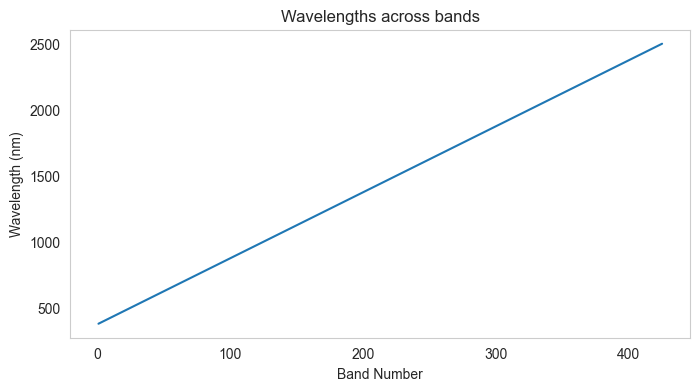

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(wavelengths)+1), wavelengths)
plt.xlabel("Band Number")
plt.ylabel("Wavelength (nm)")
plt.title("Wavelengths across bands")
plt.grid()
plt.show()


Wavelength range: approximately 376 nm → 2500 nm.
This range spans:
1. UV-VIS (Ultraviolet–Visible): ~380–700 nm
2. NIR (Near-Infrared): ~700–1300 nm
3. SWIR (Shortwave Infrared): ~1300–2500 nm

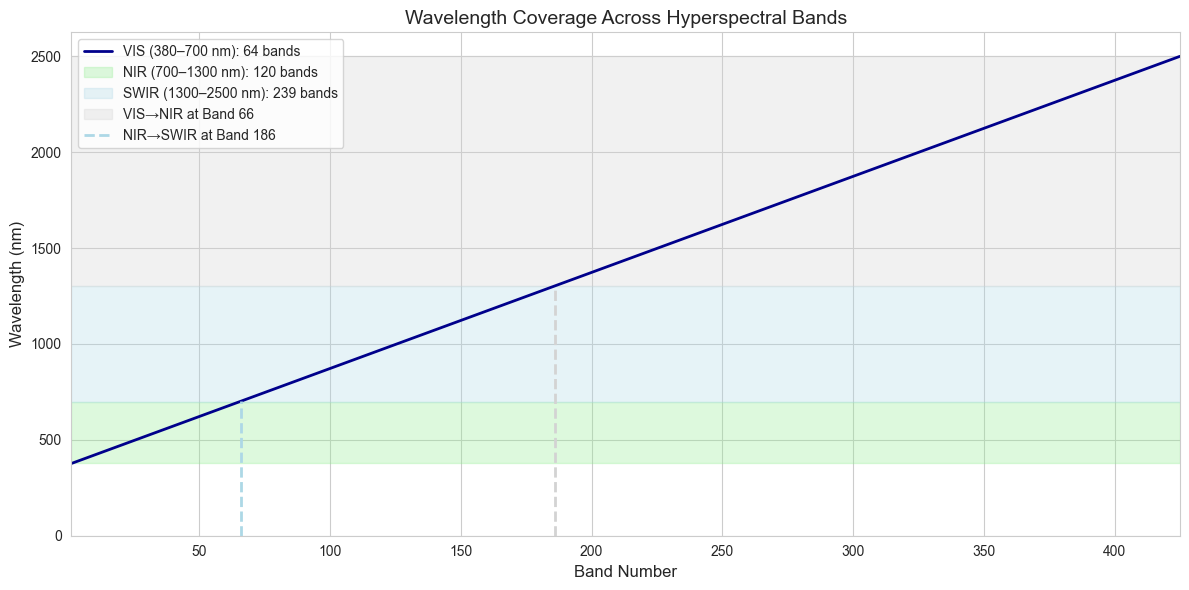

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# convert to numpy if xarray
wavelengths_np = wavelengths.values if hasattr(wavelengths, 'values') else wavelengths
bands = np.arange(1, len(wavelengths_np)+1)

# compute counts
vis_bands = int(np.sum((wavelengths_np >= 380) & (wavelengths_np <= 700)))
nir_bands = int(np.sum((wavelengths_np > 700) & (wavelengths_np <= 1300)))
swir_bands = int(np.sum((wavelengths_np > 1300) & (wavelengths_np <= 2500)))

# find band indices where category changes
nir_start_idx = np.argmax(wavelengths_np > 700)
swir_start_idx = np.argmax(wavelengths_np > 1300)

# plot
plt.figure(figsize=(12, 6))
plt.plot(bands, wavelengths_np, color="darkblue", lw=2, label="Wavelength vs Band")

plt.xlabel("Band Number", fontsize=12)
plt.ylabel("Wavelength (nm)", fontsize=12)
plt.title("Wavelength Coverage Across Hyperspectral Bands", fontsize=14)

# shaded regions
plt.axhspan(380, 700, color="lightgreen", alpha=0.3)
plt.axhspan(700, 1300, color="lightblue", alpha=0.3)
plt.axhspan(1300, 2500, color="lightgray", alpha=0.3)

# vertical lines at transition bands, starting from curve down to 0
plt.vlines(
    x=nir_start_idx+1, ymin=0, ymax=wavelengths_np[nir_start_idx],
    color="lightblue", linestyle="--", lw=2, 
    label=f"VIS→NIR at Band {nir_start_idx+1}"
)

plt.vlines(
    x=swir_start_idx+1, ymin=0, ymax=wavelengths_np[swir_start_idx],
    color="lightgray", linestyle="--", lw=2, 
    label=f"NIR→SWIR at Band {swir_start_idx+1}"
)

# legend with band counts
plt.legend([
    f"VIS (380–700 nm): {vis_bands} bands",
    f"NIR (700–1300 nm): {nir_bands} bands",
    f"SWIR (1300–2500 nm): {swir_bands} bands",
    f"VIS→NIR at Band {nir_start_idx+1}",
    f"NIR→SWIR at Band {swir_start_idx+1}"
], loc="upper left", fontsize=10)

plt.ylim(bottom=0)  
plt.xlim(1, len(wavelengths_np)) 
plt.tight_layout()
plt.show()


# RGB image

In [39]:
target_wavelengths = [650, 550, 450]  # R, G, B

band_indices = []
for target in target_wavelengths:
    idx = np.argmin(np.abs(wavelengths_np - target))
    band_indices.append(idx)

print(f"Band indices for R, G, B: {band_indices}")
print(f"Actual wavelengths: {[wavelengths_np[i] for i in band_indices]}")


Band indices for R, G, B: [np.int64(55), np.int64(35), np.int64(15)]
Actual wavelengths: [np.float64(652.199576), np.float64(552.0195759999999), np.float64(451.84957599999996)]


| Color    | Target Wavelength (nm) | Closest Band Index | Actual Wavelength |
| -------- | ---------------------- | ------------------ | ----------------- |
|  Red     | 650                    | 55                 | 652.20            |
|  Green   | 550                    | 35                 | 552.02            |
|  Blue    | 450                    | 15                 | 451.85            |


In [40]:
# load the 3 RGB bands as a (3, y, x) numpy array
rgb_cube = cube.isel(band=band_indices).compute()

In [41]:
print(rgb_cube.shape)
print(rgb_cube.dtype)


(3, 11781, 764)
float32


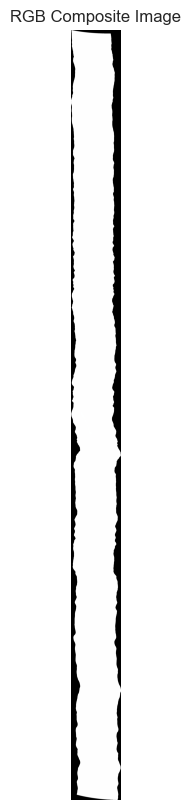

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_band(band):
    p2, p98 = np.percentile(band, (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)

rgb_img = np.stack([normalize_band(rgb_cube[i]) for i in range(3)], axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_img)
plt.title("RGB Composite Image")
plt.axis("off")
plt.show()


In [43]:
for i, color in enumerate(["Red", "Green", "Blue"]):
    print(f"{color} band min: {rgb_cube[i].min().compute()}, max: {rgb_cube[i].max().compute()}")


Red band min: <xarray.DataArray ()> Size: 4B
array(-9999., dtype=float32)
Coordinates:
    wavelength   float64 8B 652.2
    band         int64 8B 56
    spatial_ref  int64 8B 0, max: <xarray.DataArray ()> Size: 4B
array(0.41553852, dtype=float32)
Coordinates:
    wavelength   float64 8B 652.2
    band         int64 8B 56
    spatial_ref  int64 8B 0
Green band min: <xarray.DataArray ()> Size: 4B
array(-9999., dtype=float32)
Coordinates:
    wavelength   float64 8B 552.0
    band         int64 8B 36
    spatial_ref  int64 8B 0, max: <xarray.DataArray ()> Size: 4B
array(0.30255884, dtype=float32)
Coordinates:
    wavelength   float64 8B 552.0
    band         int64 8B 36
    spatial_ref  int64 8B 0
Blue band min: <xarray.DataArray ()> Size: 4B
array(-9999., dtype=float32)
Coordinates:
    wavelength   float64 8B 451.8
    band         int64 8B 16
    spatial_ref  int64 8B 0, max: <xarray.DataArray ()> Size: 4B
array(0.1946939, dtype=float32)
Coordinates:
    wavelength   float64 8B 451.8

Normalized the bands

Hyperspectral sensors record reflectance/radiance values, which are not in the 0–1 (or 0–255) range that displays properly on a screen. The data also included invalid (masked) pixels marked as -9999 which was giving a washed out image.  [ similar is done in QGIS software as well]

1. Converted -9999 to NaN (masked).
2. Stretched the valid pixel values between their 2nd and 98th percentiles 
3. Rescaled to [0, 1] and filled NaNs with 0.
4. This step is critical — otherwise you would just see a black or washed‑out image.

In [44]:
def normalize_band(band):
    band_np = band.values  # convert to numpy array
    band_np = np.where(band_np == -9999, np.nan, band_np)  # mask no-data
    p2, p98 = np.nanpercentile(band_np, (2, 98))
    normed = (band_np - p2) / (p98 - p2)
    return np.clip(np.nan_to_num(normed, nan=0), 0, 1)  # fill NaN with 0


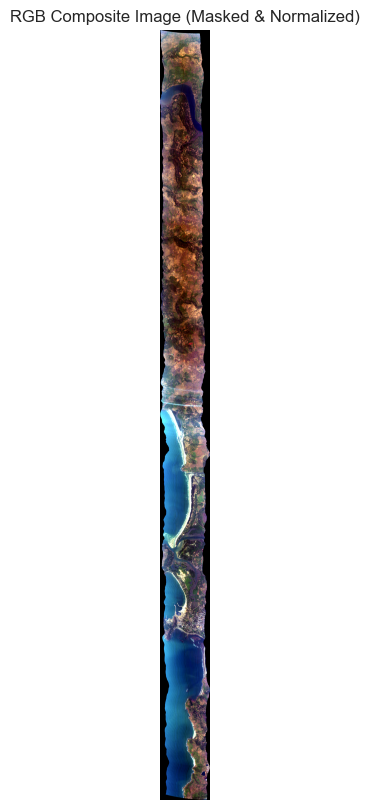

In [45]:
rgb_img = np.stack([normalize_band(rgb_cube[i]) for i in range(3)], axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_img)
plt.title("RGB Composite Image (Masked & Normalized)")
plt.axis("off")
plt.show()

In [46]:
print(cube.attrs)


{'wavelength_units': 'Nanometers', 'Band_1': '376.719576 Nanometers', 'Band_2': '381.729576 Nanometers', 'Band_3': '386.739576 Nanometers', 'Band_4': '391.749576 Nanometers', 'Band_5': '396.749576 Nanometers', 'Band_6': '401.759576 Nanometers', 'Band_7': '406.76957600000003 Nanometers', 'Band_8': '411.77957599999996 Nanometers', 'Band_9': '416.789576 Nanometers', 'Band_10': '421.799576 Nanometers', 'Band_11': '426.80957600000005 Nanometers', 'Band_12': '431.819576 Nanometers', 'Band_13': '436.819576 Nanometers', 'Band_14': '441.829576 Nanometers', 'Band_15': '446.839576 Nanometers', 'Band_16': '451.84957599999996 Nanometers', 'Band_17': '456.859576 Nanometers', 'Band_18': '461.869576 Nanometers', 'Band_19': '466.87957600000004 Nanometers', 'Band_20': '471.87957600000004 Nanometers', 'Band_21': '476.889576 Nanometers', 'Band_22': '481.899576 Nanometers', 'Band_23': '486.909576 Nanometers', 'Band_24': '491.919576 Nanometers', 'Band_25': '496.929576 Nanometers', 'Band_26': '501.9395760000

'description': '  AVIRIS-NG Measured Radiances in uW nm-1 cm-2 sr-1'

## Vegetation, Water, and Soil Index Analysis

In this step, I computed three widely used spectral indices from the hyperspectral reflectance cube: NDVI, NDWI, and BSI. These indices help distinguish different land cover types (vegetation, water, bare soil) based on their spectral properties.

### NDVI — Normalized Difference Vegetation Index

$$
NDVI = \frac{NIR - RED}{NIR + RED}
$$

**Description:**
NDVI measures the contrast between strong chlorophyll absorption in the red band and high reflectance in the near-infrared (NIR) band. It is a good indicator of live green vegetation.

| NDVI value | Land cover type           |
| ---------- | ------------------------- |
| > 0.6      | Dense, healthy vegetation |
| \~ 0.2     | Bare soil                 |
| < 0        | Water or non-vegetated    |

**Representative pixels (row, col):**

* Vegetation (highest NDVI): `(10881, 655)`
* Water (lowest NDVI): `(11755, 392)`
* Soil (NDVI ≈ 0.2): `(838, 383)`

---

### NDWI — Normalized Difference Water Index

$$
NDWI = \frac{GREEN - NIR}{GREEN + NIR}
$$

**Description:**
NDWI enhances the presence of water by contrasting high green reflectance and low NIR reflectance typical of water bodies. It also highlights soil moisture.

| NDWI value | Land cover type       |
| ---------- | --------------------- |
| > 0.3      | Water bodies          |
| \~ 0       | Bare soil or built-up |
| < 0        | Dry vegetation        |

**Representative pixels (row, col):**

* Water (highest NDWI): `(11755, 392)`
* Dry (lowest NDWI): `(3214, 543)`
* Transition (NDWI ≈ 0): `(7855, 272)`

---

### BSI — Bare Soil Index

$$
BSI = \frac{(SWIR + RED) - (NIR + BLUE)}{(SWIR + RED) + (NIR + BLUE)}
$$

**Description:**
BSI enhances the contrast of bare soil by emphasizing its characteristic spectral slope, which differs from vegetation and water.

| BSI value | Land cover type  |
| --------- | ---------------- |
| > 0.4     | Bare soil        |
| \~ 0      | Transition zones |
| < 0       | Vegetation       |

**Representative pixels (row, col):**

* Bare soil (highest BSI): `(8006, 565)`
* Vegetation (lowest BSI): `(11754, 384)`
* Transition (BSI ≈ 0): `(11024, 522)`




In [49]:
# Find band indices for relevant wavelengths
nir_band_idx = np.argmin(np.abs(wavelengths_np - 850))
red_band_idx = np.argmin(np.abs(wavelengths_np - 650))
green_band_idx = np.argmin(np.abs(wavelengths_np - 550))
blue_band_idx = np.argmin(np.abs(wavelengths_np - 450))
swir_band_idx = np.argmin(np.abs(wavelengths_np - 1650))

# Extract and load reflectance for each band
nir = cube[nir_band_idx].compute().values
red = cube[red_band_idx].compute().values
green = cube[green_band_idx].compute().values
blue = cube[blue_band_idx].compute().values
swir = cube[swir_band_idx].compute().values

# Replace no-data with NaN
for band in [nir, red, green, blue, swir]:
    band[band == -9999] = np.nan

# Compute indices
ndvi = (nir - red) / (nir + red)
ndwi = (green - nir) / (green + nir)
bsi  = ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue))

In [61]:
results = {}

### NDVI
results['NDVI'] = {
    'vegetation_idx': np.unravel_index(np.nanargmax(ndvi), ndvi.shape),
    'water_idx': np.unravel_index(np.nanargmin(ndvi), ndvi.shape),
    'soil_idx': np.unravel_index(np.nanargmin(np.abs(ndvi - 0.2)), ndvi.shape)
}

### NDWI
results['NDWI'] = {
    'water_idx': np.unravel_index(np.nanargmax(ndwi), ndwi.shape),
    'dry_idx': np.unravel_index(np.nanargmin(ndwi), ndwi.shape),
    'transition_idx': np.unravel_index(np.nanargmin(np.abs(ndwi)), ndwi.shape)
}

### BSI
results['BSI'] = {
    'bare_soil_idx': np.unravel_index(np.nanargmax(bsi), bsi.shape),
    'vegetation_idx': np.unravel_index(np.nanargmin(bsi), bsi.shape),
    'transition_idx': np.unravel_index(np.nanargmin(np.abs(bsi)), bsi.shape)
}

# Print results
for index, classes in results.items():
    print(f"\n=== {index} ===")
    for cls, idx in classes.items():
        print(f"{cls}: {idx}")



=== NDVI ===
vegetation_idx: (np.int64(10881), np.int64(655))
water_idx: (np.int64(11755), np.int64(392))
soil_idx: (np.int64(838), np.int64(383))

=== NDWI ===
water_idx: (np.int64(11755), np.int64(392))
dry_idx: (np.int64(3214), np.int64(543))
transition_idx: (np.int64(7855), np.int64(272))

=== BSI ===
bare_soil_idx: (np.int64(8006), np.int64(565))
vegetation_idx: (np.int64(11754), np.int64(384))
transition_idx: (np.int64(11024), np.int64(522))


 `KMeans or hierarchical clustering of spectra an be started at these points`

In [58]:
import matplotlib.pyplot as plt

# Representative pixels (row, col)
veg_idx = (10881, 655)
water_idx = (11755, 392)
soil_idx = (838, 383)

# Extract spectra
veg_spectrum = cube[:, veg_idx[0], veg_idx[1]].compute().values
water_spectrum = cube[:, water_idx[0], water_idx[1]].compute().values
soil_spectrum = cube[:, soil_idx[0], soil_idx[1]].compute().values

# Mask no-data values
veg_spectrum = np.where(veg_spectrum == -9999, np.nan, veg_spectrum)
water_spectrum = np.where(water_spectrum == -9999, np.nan, water_spectrum)
soil_spectrum = np.where(soil_spectrum == -9999, np.nan, soil_spectrum)

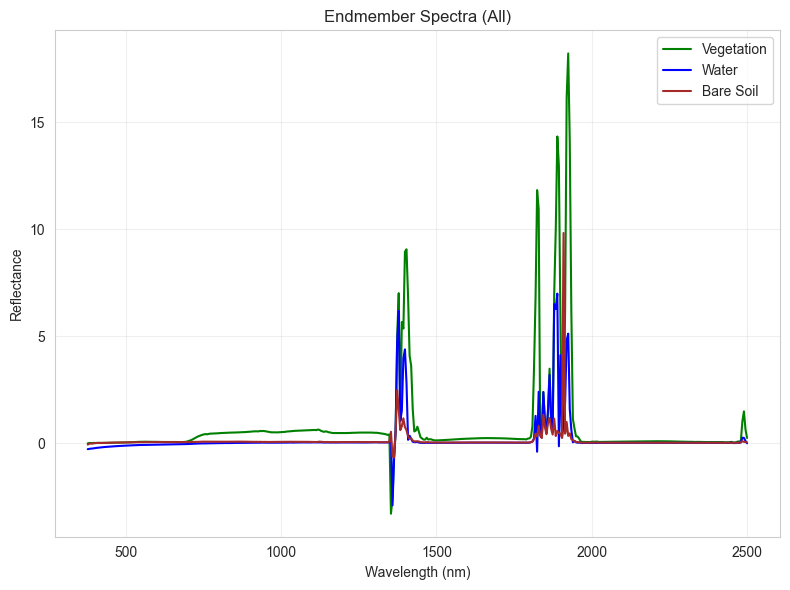

In [59]:
fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(wavelengths_np, veg_spectrum, label='Vegetation', color='green')
ax1.plot(wavelengths_np, water_spectrum, label='Water', color='blue')
ax1.plot(wavelengths_np, soil_spectrum, label='Bare Soil', color='brown')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Reflectance')
ax1.set_title('Endmember Spectra (All)')
ax1.legend()
ax1.grid(True, alpha=0.3)
fig1.tight_layout()



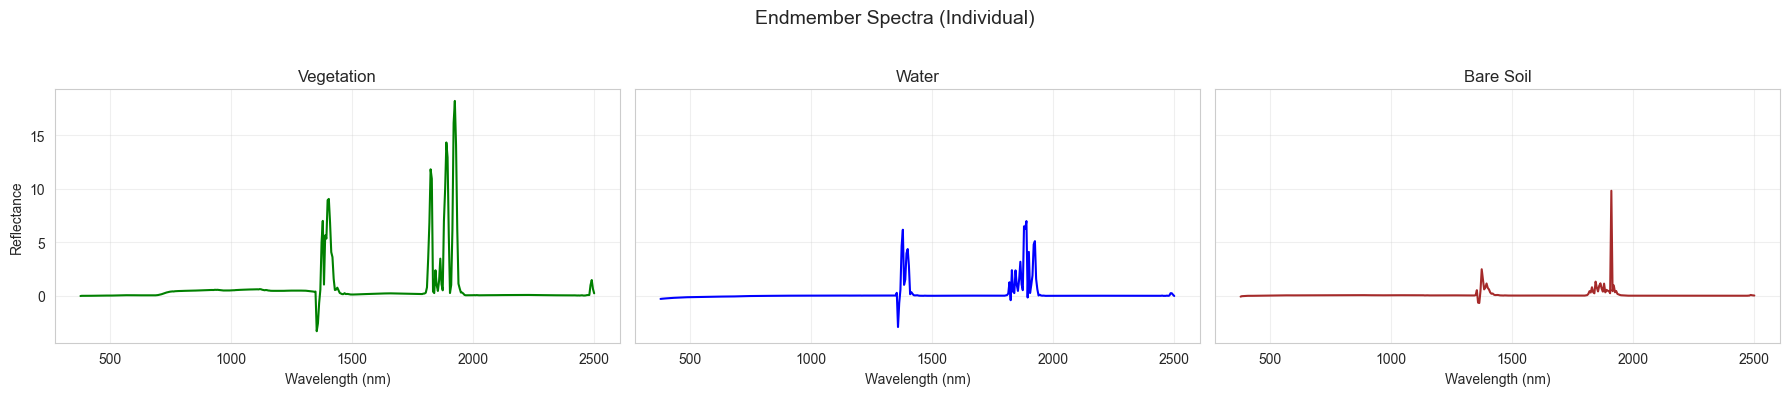

In [60]:
fig2, axes = plt.subplots(1, 3, figsize=(18,4), sharey=True)

axes[0].plot(wavelengths_np, veg_spectrum, color='green')
axes[0].set_title('Vegetation')
axes[0].set_xlabel('Wavelength (nm)')
axes[0].set_ylabel('Reflectance')
axes[0].grid(True, alpha=0.3)

axes[1].plot(wavelengths_np, water_spectrum, color='blue')
axes[1].set_title('Water')
axes[1].set_xlabel('Wavelength (nm)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(wavelengths_np, soil_spectrum, color='brown')
axes[2].set_title('Bare Soil')
axes[2].set_xlabel('Wavelength (nm)')
axes[2].grid(True, alpha=0.3)

fig2.suptitle('Endmember Spectra (Individual)', fontsize=14)
fig2.tight_layout(rect=[0, 0, 1, 0.95])



In [63]:
# define the known endmember locations
vegetation_idx = (10881, 655)    
water_idx = (11755, 392)         
soil_idx = (838, 383)           

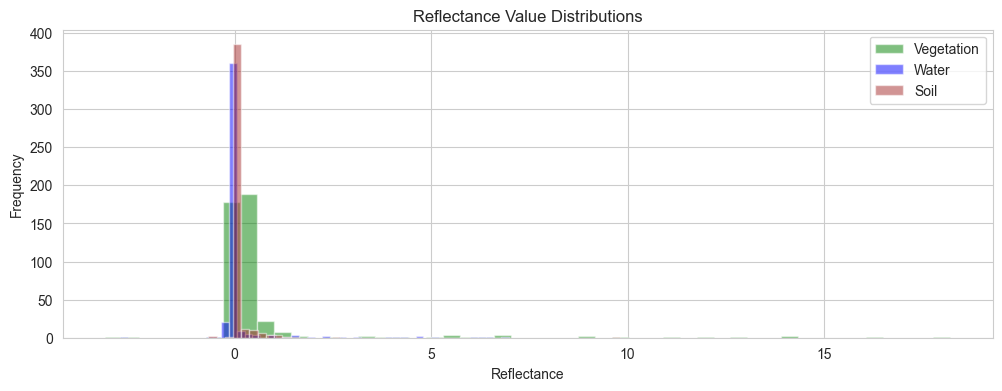

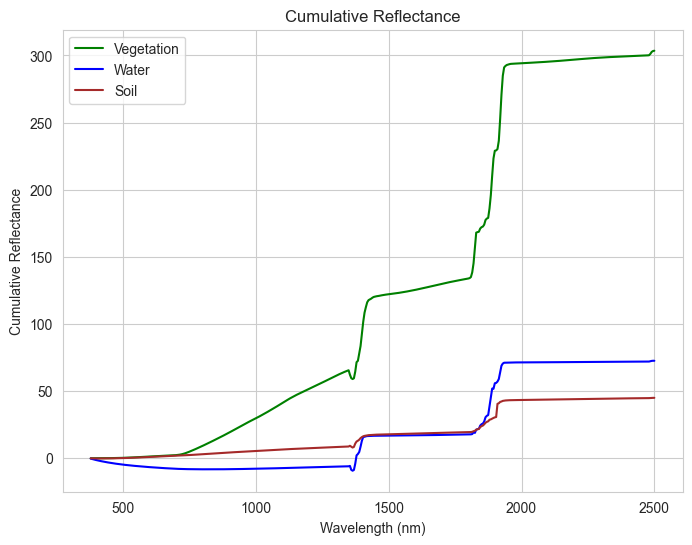

Spectral Angle Vegetation–Water: 0.2403
Spectral Angle Vegetation–Soil: 0.7041
Spectral Angle Soil–Water: 0.6039


In [64]:
from scipy.spatial.distance import cosine

# Extract spectra of 3 endmembers
veg_spectrum = cube[:, vegetation_idx[0], vegetation_idx[1]].compute().values
water_spectrum = cube[:, water_idx[0], water_idx[1]].compute().values
soil_spectrum = cube[:, soil_idx[0], soil_idx[1]].compute().values

veg_spectrum = np.where(veg_spectrum == -9999, np.nan, veg_spectrum)
water_spectrum = np.where(water_spectrum == -9999, np.nan, water_spectrum)
soil_spectrum = np.where(soil_spectrum == -9999, np.nan, soil_spectrum)

# Histograms
plt.figure(figsize=(12,4))
plt.hist(veg_spectrum, bins=50, alpha=0.5, label='Vegetation', color='green')
plt.hist(water_spectrum, bins=50, alpha=0.5, label='Water', color='blue')
plt.hist(soil_spectrum, bins=50, alpha=0.5, label='Soil', color='brown')
plt.title("Reflectance Value Distributions")
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Cumulative reflectance
plt.figure(figsize=(8,6))
plt.plot(wavelengths_np, np.cumsum(veg_spectrum), label='Vegetation', color='green')
plt.plot(wavelengths_np, np.cumsum(water_spectrum), label='Water', color='blue')
plt.plot(wavelengths_np, np.cumsum(soil_spectrum), label='Soil', color='brown')
plt.title("Cumulative Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Cumulative Reflectance")
plt.legend()
plt.show()

# Spectral Angle Mapper (SAM) — cosine distance
veg_water_angle = cosine(veg_spectrum, water_spectrum)
veg_soil_angle = cosine(veg_spectrum, soil_spectrum)
soil_water_angle = cosine(soil_spectrum, water_spectrum)

print(f"Spectral Angle Vegetation–Water: {veg_water_angle:.4f}")
print(f"Spectral Angle Vegetation–Soil: {veg_soil_angle:.4f}")
print(f"Spectral Angle Soil–Water: {soil_water_angle:.4f}")


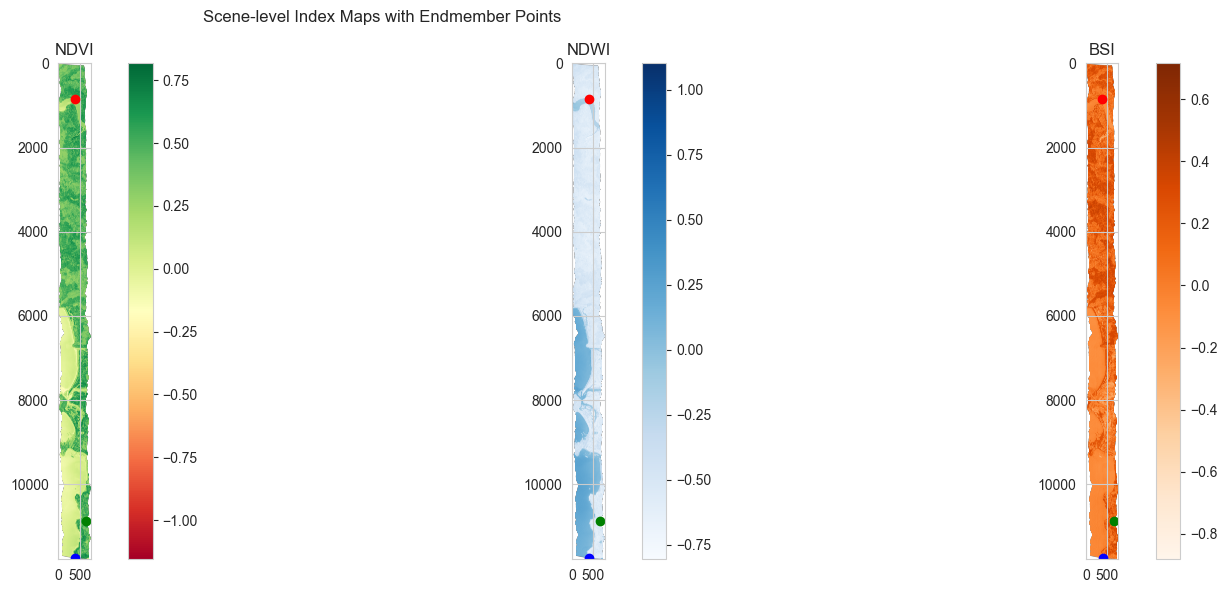

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

im0 = axes[0].imshow(ndvi, cmap='RdYlGn')
axes[0].set_title("NDVI")
axes[0].plot(vegetation_idx[1], vegetation_idx[0], 'go')  # veg
axes[0].plot(soil_idx[1], soil_idx[0], 'ro')             # soil
axes[0].plot(water_idx[1], water_idx[0], 'bo')           # water
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(ndwi, cmap='Blues')
axes[1].set_title("NDWI")
axes[1].plot(vegetation_idx[1], vegetation_idx[0], 'go')
axes[1].plot(soil_idx[1], soil_idx[0], 'ro')
axes[1].plot(water_idx[1], water_idx[0], 'bo')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(bsi, cmap='Oranges')
axes[2].set_title("BSI")
axes[2].plot(vegetation_idx[1], vegetation_idx[0], 'go')
axes[2].plot(soil_idx[1], soil_idx[0], 'ro')
axes[2].plot(water_idx[1], water_idx[0], 'bo')
plt.colorbar(im2, ax=axes[2])

plt.suptitle("Scene-level Index Maps with Endmember Points")
plt.tight_layout()
plt.show()


On top of these maps, the automatically selected endmember pixels for vegetation, water, and soil (identified earlier) are overlaid for reference.

Red dot: Vegetation endmember.

Green dot: Water endmember.

Blue dot: Soil endmember.

These maps confirm that the endmember pixels correspond to expected areas in the scene and give confidence in the endmember selection.

In [66]:
veg_mean = np.nanmean(veg_spectrum)
veg_std = np.nanstd(veg_spectrum)

water_mean = np.nanmean(water_spectrum)
water_std = np.nanstd(water_spectrum)

soil_mean = np.nanmean(soil_spectrum)
soil_std = np.nanstd(soil_spectrum)

print(f"Vegetation: mean={veg_mean:.4f}, std={veg_std:.4f}")
print(f"Water: mean={water_mean:.4f}, std={water_std:.4f}")
print(f"Soil: mean={soil_mean:.4f}, std={soil_std:.4f}")


Vegetation: mean=0.7141, std=2.1609
Water: mean=0.1708, std=0.8911
Soil: mean=0.1059, std=0.5219


1. Vegetation has the highest mean reflectance and also the highest variability (std), which is expected — vegetation shows strong reflectance in NIR and dips in red, creating large differences between bands.
2. Water is low and quite flat — water generally absorbs a lot in most bands except a small peak around ~450–550nm.
3. Soil has an intermediate and more uniform reflectance with moderate variability

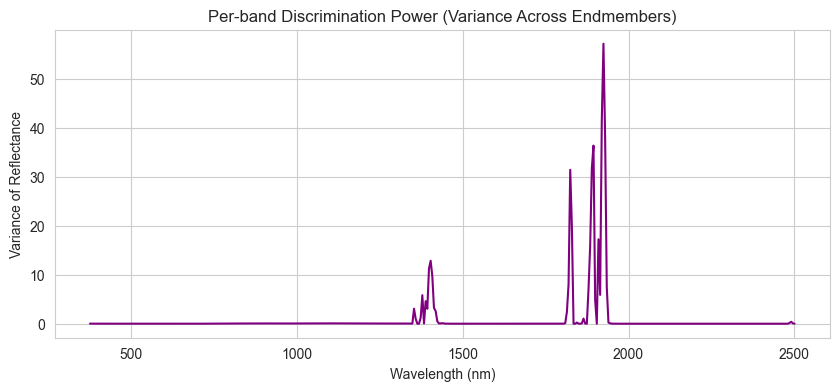

Band with max discrimination: 1924.4 nm (Variance: 57.1391)


In [69]:
veg_spec = veg_spectrum
water_spec = water_spectrum
soil_spec = soil_spectrum

stack = np.vstack([veg_spec, water_spec, soil_spec])  # shape: (3, bands)
band_variance = np.var(stack, axis=0)                 # shape: (bands,)

plt.figure(figsize=(10,4))
plt.plot(wavelengths_np, band_variance, color='purple')
plt.title("Per-band Discrimination Power (Variance Across Endmembers)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Variance of Reflectance")
plt.grid(True)
plt.show()

best_band_idx = np.argmax(band_variance)
print(f"Band with max discrimination: {wavelengths_np[best_band_idx]:.1f} nm (Variance: {band_variance[best_band_idx]:.4f})")


C:\Users\UTKARSH GUPTA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


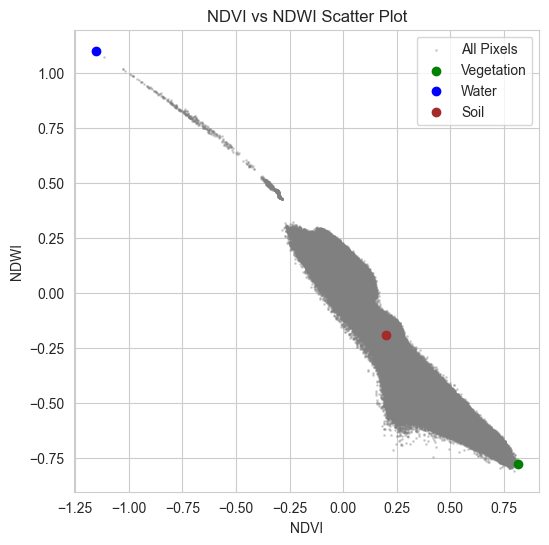

In [70]:
plt.figure(figsize=(6,6))
plt.scatter(ndvi.flatten(), ndwi.flatten(), s=1, alpha=0.3, c='gray', label='All Pixels')

# Highlight the endmembers
plt.scatter(ndvi[veg_idx], ndwi[veg_idx], color='green', label='Vegetation')
plt.scatter(ndvi[water_idx], ndwi[water_idx], color='blue', label='Water')
plt.scatter(ndvi[soil_idx], ndwi[soil_idx], color='brown', label='Soil')

plt.title("NDVI vs NDWI Scatter Plot")
plt.xlabel("NDVI")
plt.ylabel("NDWI")
plt.legend()
plt.grid(True)
plt.show()


In [71]:
import random

def sample_pixels(mask, n=100):
    ys, xs = np.where(mask)
    indices = list(zip(ys, xs))
    if len(indices) > n:
        indices = random.sample(indices, n)
    return indices

# Define thresholds
veg_mask = ndvi > 0.6
water_mask = ndwi > 0.3
soil_mask = bsi > 0.3

# Sample pixels
veg_samples = sample_pixels(veg_mask, n=100)
water_samples = sample_pixels(water_mask, n=100)
soil_samples = sample_pixels(soil_mask, n=100)

print(f"Vegetation pixels sampled: {len(veg_samples)}")
print(f"Water pixels sampled: {len(water_samples)}")
print(f"Soil pixels sampled: {len(soil_samples)}")


Vegetation pixels sampled: 100
Water pixels sampled: 100
Soil pixels sampled: 100


In [ ]:
def extract_spectra(pixels, cube):
    """
    Extract spectral data from a hyperspectral cube for given pixel coordinates.

    This function takes a list of pixel coordinates and extracts the corresponding
    spectral data from a hyperspectral data cube. It computes and returns the
    spectral values for each specified pixel.

    Parameters:
    pixels (list of tuples): A list of (y, x) coordinate tuples representing the pixels from which to extract spectra.
    cube (xarray.DataArray): The hyperspectral data cube from which to extract the spectral data. Expected to have dimensions (band, y, x).

    Returns:
    numpy.ndarray: A 2D array of spectral data. Each row corresponds to a pixel, and each column represents a spectral band.
    """
    spectra = []
    for y, x in pixels:
        spec = cube[:, y, x].compute().values
        spectra.append(spec)
    return np.array(spectra)

veg_spectra = extract_spectra(veg_samples, cube)
water_spectra = extract_spectra(water_samples, cube)
soil_spectra = extract_spectra(soil_samples, cube)

# Compute mean & std
veg_mean = np.nanmean(veg_spectra, axis=0)
veg_std = np.nanstd(veg_spectra, axis=0)

water_mean = np.nanmean(water_spectra, axis=0)
water_std = np.nanstd(water_spectra, axis=0)

soil_mean = np.nanmean(soil_spectra, axis=0)
soil_std = np.nanstd(soil_spectra, axis=0)


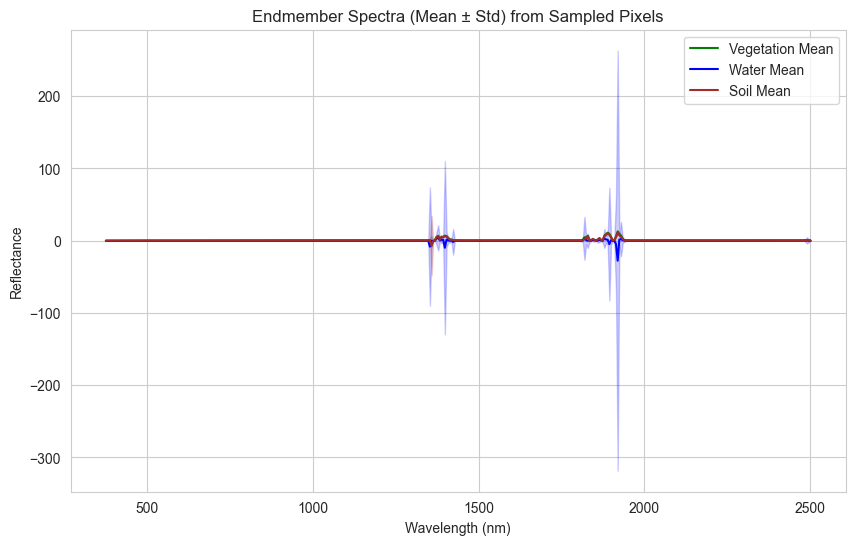

In [73]:
plt.figure(figsize=(10,6))

for mean, std, label, color in [
    (veg_mean, veg_std, 'Vegetation', 'green'),
    (water_mean, water_std, 'Water', 'blue'),
    (soil_mean, soil_std, 'Soil', 'brown')
]:
    plt.plot(wavelengths_np, mean, color=color, label=f"{label} Mean")
    plt.fill_between(wavelengths_np, mean-std, mean+std, color=color, alpha=0.2)

plt.title("Endmember Spectra (Mean ± Std) from Sampled Pixels")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.grid(True)
plt.show()


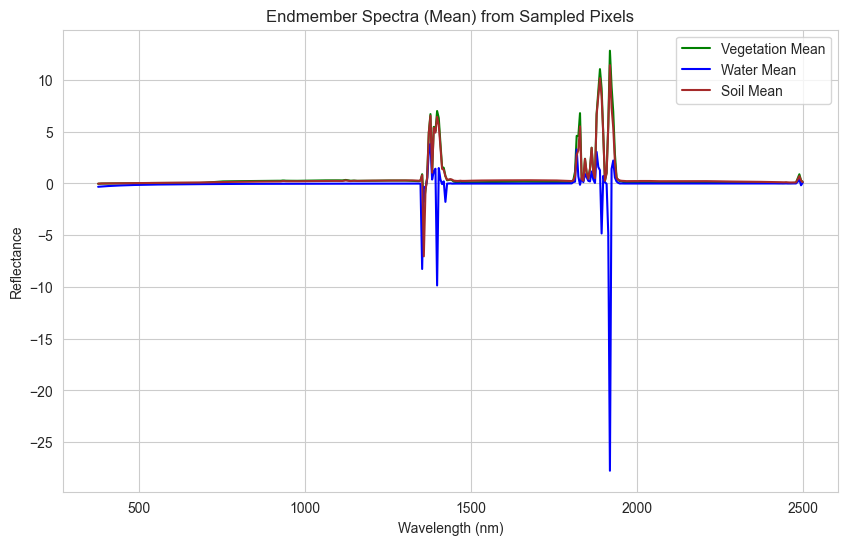

In [74]:
plt.figure(figsize=(10,6))

plt.plot(wavelengths_np, veg_mean, color='green', label='Vegetation Mean')
plt.plot(wavelengths_np, water_mean, color='blue', label='Water Mean')
plt.plot(wavelengths_np, soil_mean, color='brown', label='Soil Mean')

plt.title("Endmember Spectra (Mean) from Sampled Pixels")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.grid(True)
plt.show()


### **Data Understanding & Preprocessing**

* Read the **AVIRIS-NG corrected reflectance (`corr`) cube.**
* Parsed metadata (wavelengths, dimensions, etc).
* Masked invalid / no-data pixels (`-9999`).
* Computed **RGB visualization**.

### **Basic Vegetation Indices**

* Computed:

  * **NDVI** (vegetation greenness).
  * **NDWI** (water content).
  * **BSI** (bare soil index).

* Mapped indices spatially with colormaps and overlaid endmember locations.

### **Endmember Sampling**

* Sampled a **single pixel each** representing:

  * Vegetation (max NDVI)
  * Water (max NDWI)
  * Soil (max BSI / intermediate NDVI).

### **Spectral Signature Analysis**

* Plotted spectral signatures (reflectance vs wavelength) for each sampled pixel.
* Plotted cumulative reflectance curves.
* Plotted mean ± std bands for variability.
* Scene-level NDVI/NDWI/BSI maps with endmember points.

### **Descriptive Stats**

* Computed mean and standard deviation of spectra for each endmember class.
* Visualized reflectance means only.



`High variability may mean mixed pixels — I might refine your endmember selection later.`